In [1]:
from Bio import SeqIO
import pandas as pd

# Paths to enzyme and non-enzyme FASTA files
enz_fasta = "/home/rithwik/AI_ML/Week_2_Enzyme_Classification/data/sprot_enz_seq.fasta.txt"
nonenz_fasta = "/home/rithwik/AI_ML/Week_2_Enzyme_Classification/data/sprot_nonenz_seq.fasta.txt"

def fasta_to_df(fasta_file, label):
    """
    Parse a FASTA file and return a DataFrame with sequence and label.
    """
    records = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        seq_str = str(record.seq)
        records.append([seq_str, label])
    return pd.DataFrame(records, columns=["sequence", "label"])

# Convert both files
df_enz = fasta_to_df(enz_fasta, 1)
df_nonenz = fasta_to_df(nonenz_fasta, 0)

# Combine into one dataset
df_all = pd.concat([df_enz, df_nonenz], ignore_index=True)

print("Dataset size:", df_all.shape)
print(df_all.head())
print(df_all['label'].value_counts())


Dataset size: (193425, 2)
                                            sequence  label
0  MSSYENHQALHSLTLGKSTDYRDTYDASLLQGVPRSLNRDPLGLTA...      1
1  MEQLVNELIEANVGRVLVDEPLARYTTMKIGGPADILIVPKHVAGI...      1
2  MTDYVTDIAVIGAGPVGIFTVFQAGMLKMRCCVIDALSEIGGQCLA...      1
3  MTEGRNKEELEDITLLGNQNNKYDFDYRPDVLESFDNKHQGRDYFV...      1
4  MFYPVIKKALFQLDPERAHELTFQQLRRITNTPFEFLVRQSVPTKP...      1
label
0    128475
1     64950
Name: count, dtype: int64


In [2]:
# ======================
# Cell 1: Inspect dataset
# ======================

import numpy as np
import pandas as pd

# 1. Missing values
print("Missing sequences:", df_all['sequence'].isna().sum())

# 2. Sequence length stats
seq_lengths = df_all['sequence'].apply(len)
print("Min length:", seq_lengths.min())
print("Max length:", seq_lengths.max())
print("Mean length:", seq_lengths.mean())
print("Median length:", seq_lengths.median())

# 3. Sequences longer than 2500 aa
long_seqs = df_all[df_all["sequence"].str.len() > 2500]
print("Sequences longer than 2500 aa:", len(long_seqs))

# 4. Duplicates
dup_count = df_all.duplicated(subset=["sequence"]).sum()
print("Duplicate sequences:", dup_count)

# 5. Overlaps between enzyme/non-enzyme
dup_across_labels = df_all.groupby("sequence")["label"].nunique().eq(2).sum()
print("Sequences appearing in BOTH enzyme and non-enzyme sets:", dup_across_labels)


Missing sequences: 0
Min length: 51
Max length: 35213
Mean length: 396.84984877859637
Median length: 311.0
Sequences longer than 2500 aa: 679
Duplicate sequences: 31
Sequences appearing in BOTH enzyme and non-enzyme sets: 31


In [3]:
# ============================
# Cell 2: Clean the dataset
# ============================

# Remove duplicate sequences
before_dupes = len(df_all)
df_all = df_all.drop_duplicates(subset="sequence", keep="first").reset_index(drop=True)
after_dupes = len(df_all)
print(f"Removed {before_dupes - after_dupes} duplicate sequences.")

# Remove overlaps (seqs with conflicting labels)
seq_label_counts = df_all.groupby("sequence")["label"].nunique()
overlap_seqs = seq_label_counts[seq_label_counts > 1].index
print("Sequences in both enzyme and non-enzyme sets:", len(overlap_seqs))

df_all = df_all[~df_all["sequence"].isin(overlap_seqs)].reset_index(drop=True)
print("Final dataset size after cleaning:", df_all.shape)



# Define valid amino acids (20 standard)
valid_aas = set("ACDEFGHIKLMNPQRSTVWY")

# Check for invalid amino acids
invalid_counts = {}

for seq in df_all["sequence"]:
    for ch in set(seq):
        if ch not in valid_aas:
            invalid_counts[ch] = invalid_counts.get(ch, 0) + 1

print("Sequences with invalid characters:", sum(invalid_counts.values()))
print("Invalid character counts:", invalid_counts)

# Define a function to check if sequence is valid
def is_valid(seq):
    """Return True if sequence contains only standard amino acids."""
    return all(ch in valid_aas for ch in seq)

# Drop sequences longer than 2500 aa
before = len(df_all)
df_all = df_all[df_all["sequence"].str.len() <= 2500]

# Drop sequences with invalid characters
df_all = df_all[df_all["sequence"].apply(is_valid)]

after = len(df_all)

print(f"Removed {before - after} sequences.")
print("Final dataset size after dropping invalid + long sequences:", df_all.shape)

# Check again
seq_lengths = df_all["sequence"].apply(len)
print("Min length after dropping invalid + long sequences:", seq_lengths.min())
print("Max length after dropping invalid + long sequences:", seq_lengths.max())



Removed 31 duplicate sequences.
Sequences in both enzyme and non-enzyme sets: 0
Final dataset size after cleaning: (193394, 2)
Sequences with invalid characters: 616
Invalid character counts: {'U': 101, 'X': 457, 'B': 32, 'Z': 21, 'O': 5}
Removed 1261 sequences.
Final dataset size after dropping invalid + long sequences: (192133, 2)
Min length after dropping invalid + long sequences: 51
Max length after dropping invalid + long sequences: 2499


In [4]:
# ======================
# Cell 3: Featurization
# ======================

import numpy as np
import pandas as pd
from collections import Counter
# from sklearn.preprocessing import StandardScaler  # Uncomment later if you want scaling

# --- Step 1: Define amino acid order ---
valid_aas = set("ACDEFGHIKLMNPQRSTVWY")
sorted_aa_list = sorted(valid_aas)   # alphabetical order
aa_order = sorted_aa_list            # stored for interpretability
print("Amino acids used for features:", aa_order)

# --- Step 2: Define featurization function ---
def featurize_sequence(seq, aa_order):
    """
    Convert a protein sequence into numeric features:
    - Sequence length
    - Amino acid composition (fraction of each AA)
    """
    seq = seq.upper()
    features = np.zeros(len(aa_order) + 1, dtype=float)  # preallocate 21 features
    
    # Feature 1: length
    features[0] = len(seq)
    
    # Feature 2: amino acid composition
    counts = Counter(seq)
    total = len(seq) if len(seq) > 0 else 1
    for i, aa in enumerate(aa_order, start=1):
        features[i] = counts.get(aa, 0) / total
    
    return features

# --- Step 3: Preallocate NumPy array for ALL sequences ---
n_samples = len(df_all)
n_features = 1 + len(aa_order)  # 1 (length) + 20 (AA fractions)
X = np.zeros((n_samples, n_features), dtype=float)

# Fill the matrix
for i, seq in enumerate(df_all["sequence"]):
    X[i, :] = featurize_sequence(seq, aa_order)

# Labels
y = df_all["label"].values

# --- Step 4: Build pandas DataFrame with clear column names ---
feature_names = ["Length"] + [f"Frac_{aa}" for aa in aa_order]
X_df = pd.DataFrame(X, columns=feature_names)
X_df["Label"] = y




# Example features for first sequence (readable format)
example = X_df.iloc[0].copy()  # copy to avoid modifying real data
for col in example.index:
    if col.startswith("Frac_"):
        example[col] = f"{example[col]*100:.2f}%"
print("Example features for first sequence:\n", example)

# Feature matrix head (readable format)
head_df = X_df.head().copy()
for col in head_df.columns:
    if col.startswith("Frac_"):
        head_df[col] = head_df[col].apply(lambda x: f"{x*100:.2f}%")
print("Feature matrix head:\n", head_df)




Amino acids used for features: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Example features for first sequence:
 Length     282.0
Frac_A     4.61%
Frac_C     2.13%
Frac_D     7.09%
Frac_E     6.74%
Frac_F     3.19%
Frac_G     5.32%
Frac_H     4.26%
Frac_I     4.61%
Frac_K     2.84%
Frac_L    12.77%
Frac_M     0.35%
Frac_N     5.32%
Frac_P     3.19%
Frac_Q     6.03%
Frac_R     7.09%
Frac_S     7.80%
Frac_T     4.96%
Frac_V     5.32%
Frac_W     1.77%
Frac_Y     4.61%
Label        1.0
Name: 0, dtype: object
Feature matrix head:
    Length Frac_A Frac_C Frac_D Frac_E Frac_F  Frac_G Frac_H Frac_I Frac_K  \
0   282.0  4.61%  2.13%  7.09%  6.74%  3.19%   5.32%  4.26%  4.61%  2.84%   
1   301.0  6.31%  0.33%  3.32%  7.64%  2.66%  11.63%  2.66%  8.97%  5.98%   
2   338.0  7.40%  2.66%  4.73%  4.44%  3.85%   7.69%  1.78%  9.47%  6.80%   
3   166.0  1.20%  1.81%  9.04%  7.83%  6.02%   5.42%  3.61%  7.83%  6.63%   
4   336.0  5.95%  1.19%  5

/tmp/ipykernel_57974/1535752767.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.61%' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  example[col] = f"{example[col]*100:.2f}%"


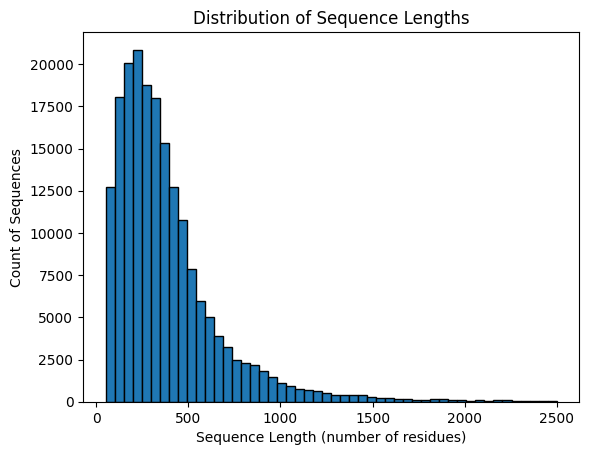

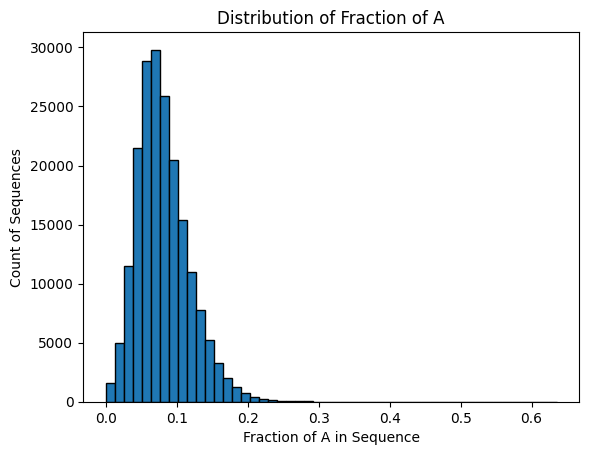

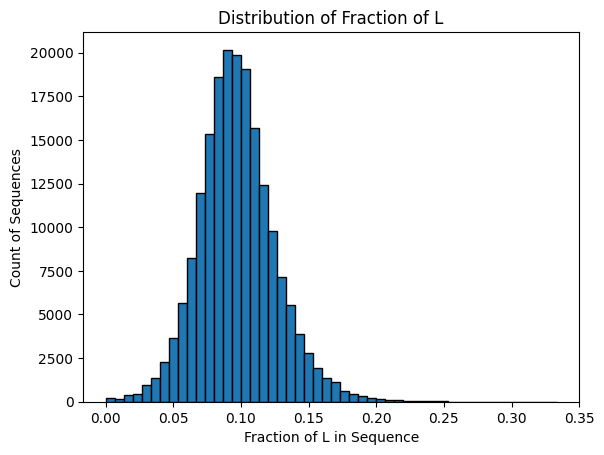

In [5]:
# ======================
# Cell 4: Visualization
# ======================

import matplotlib.pyplot as plt

# --- Histogram of sequence lengths ---
plt.hist(X_df["Length"], bins=50, edgecolor="black")
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length (number of residues)")
plt.ylabel("Count of Sequences")
plt.show()

# --- Histogram of a couple of amino acid fractions ---
for aa in ["A", "L"]:  # Alanine and Leucine as examples
    plt.hist(X_df[f"Frac_{aa}"], bins=50, edgecolor="black")
    plt.title(f"Distribution of Fraction of {aa}")
    plt.xlabel(f"Fraction of {aa} in Sequence")
    plt.ylabel("Count of Sequences")
    plt.show()


In [6]:
# ======================
# Cell 5: Scaling Length feature
# ======================

from sklearn.preprocessing import StandardScaler

# Copy feature DataFrame (excluding label for now)
features_only = X_df.drop(columns=["Label"]).copy()

# Scale only the Length column
scaler = StandardScaler()
features_only["Length"] = scaler.fit_transform(features_only[["Length"]])

# Reattach Label
X_scaled_df = features_only.copy()
X_scaled_df["Label"] = X_df["Label"].values

print("Example after scaling:")
print(X_scaled_df.head())


Example after scaling:
     Length    Frac_A    Frac_C    Frac_D    Frac_E    Frac_F    Frac_G  \
0 -0.344303  0.046099  0.021277  0.070922  0.067376  0.031915  0.053191   
1 -0.280404  0.063123  0.003322  0.033223  0.076412  0.026578  0.116279   
2 -0.155968  0.073964  0.026627  0.047337  0.044379  0.038462  0.076923   
3 -0.734426  0.012048  0.018072  0.090361  0.078313  0.060241  0.054217   
4 -0.162694  0.059524  0.011905  0.056548  0.053571  0.038690  0.098214   

     Frac_H    Frac_I    Frac_K  ...    Frac_N    Frac_P    Frac_Q    Frac_R  \
0  0.042553  0.046099  0.028369  ...  0.053191  0.031915  0.060284  0.070922   
1  0.026578  0.089701  0.059801  ...  0.033223  0.033223  0.039867  0.053156   
2  0.017751  0.094675  0.068047  ...  0.062130  0.050296  0.041420  0.026627   
3  0.036145  0.078313  0.066265  ...  0.078313  0.060241  0.018072  0.048193   
4  0.017857  0.083333  0.065476  ...  0.044643  0.053571  0.044643  0.053571   

     Frac_S    Frac_T    Frac_V    Frac_W    

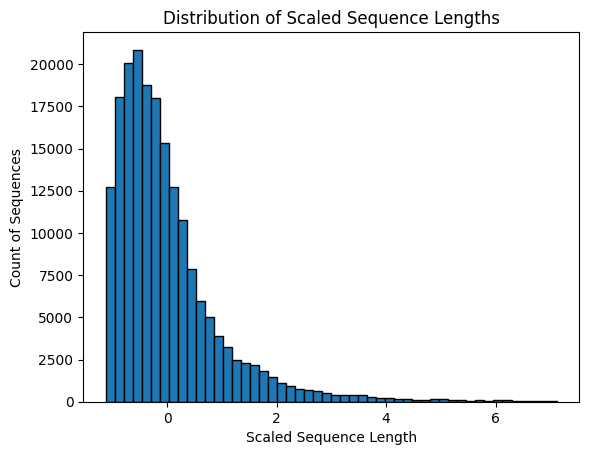

Summary statistics of scaled Length:
count    192,133.00
mean          -0.00
std            1.00
min           -1.12
25%           -0.65
50%           -0.25
75%            0.30
max            7.11
Name: Length, dtype: object


In [7]:
# ======================
# Cell 6: Visualize scaled Length
# ======================

# --- Histogram of scaled sequence lengths ---
plt.hist(X_scaled_df["Length"], bins=50, edgecolor="black")
plt.title("Distribution of Scaled Sequence Lengths")
plt.xlabel("Scaled Sequence Length")
plt.ylabel("Count of Sequences")
plt.show()


# Summary statistics of scaled Length
summary = X_scaled_df["Length"].describe()

# Format numbers: integers as normal, floats to 2 decimals
formatted_summary = summary.apply(lambda x: f"{x:,.2f}" if isinstance(x, float) else f"{int(x):,}")

# Display formatted summary
print("Summary statistics of scaled Length:")
print(formatted_summary)




In [9]:
# ======================
# Cell 7: Train/Test Split
# ======================

from sklearn.model_selection import train_test_split

# Separate features and labels
X = X_scaled_df.drop(columns=["Label"])
y = X_scaled_df["Label"]

# Stratified split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Class balance train:\n", y_train.value_counts(normalize=True))
print("Class balance test:\n", y_test.value_counts(normalize=True))


Train shape: (153706, 21)  Test shape: (38427, 21)
Class balance train:
 Label
0    0.663878
1    0.336122
Name: proportion, dtype: float64
Class balance test:
 Label
0    0.663882
1    0.336118
Name: proportion, dtype: float64



=== Logistic Regression ===
Accuracy: 0.6940
Precision: 0.5776
Recall: 0.3338
F1: 0.4231
ROC-AUC: 0.7360


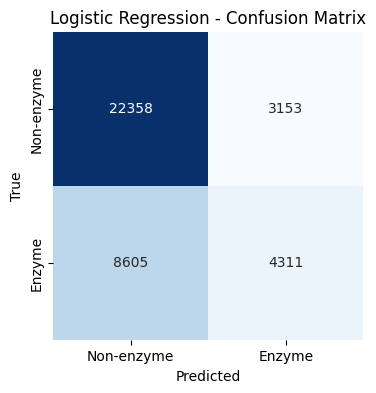

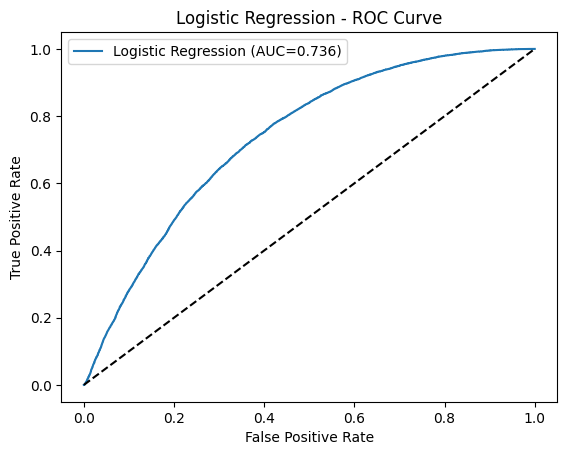


=== Random Forest ===
Accuracy: 0.7935
Precision: 0.7333
Recall: 0.6058
F1: 0.6635
ROC-AUC: 0.8671


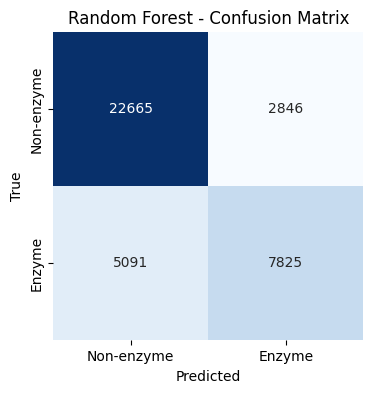

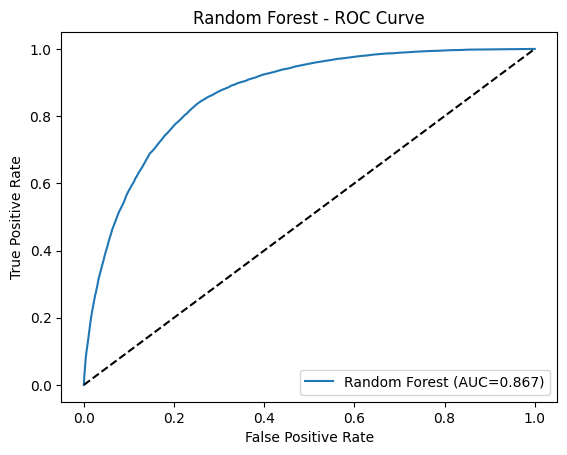

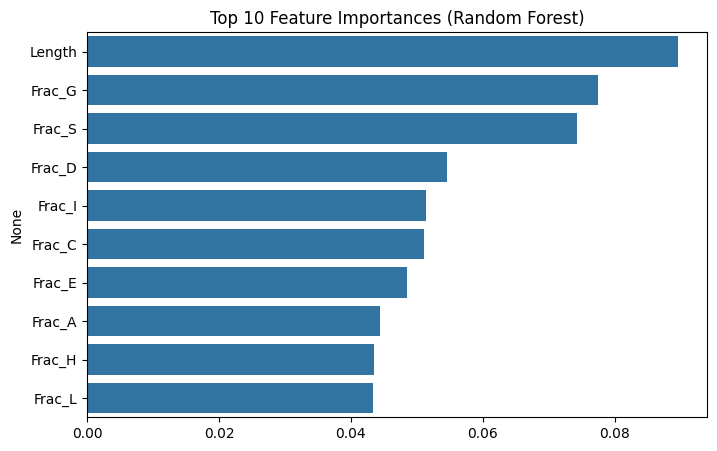

/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:00:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost ===
Accuracy: 0.7946
Precision: 0.7078
Recall: 0.6624
F1: 0.6844
ROC-AUC: 0.8665


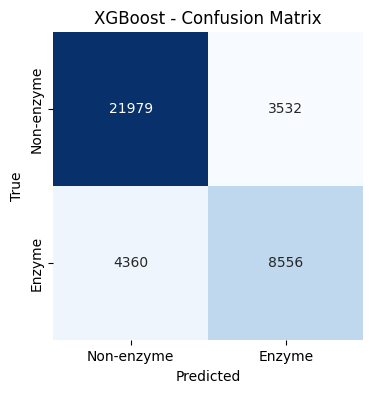

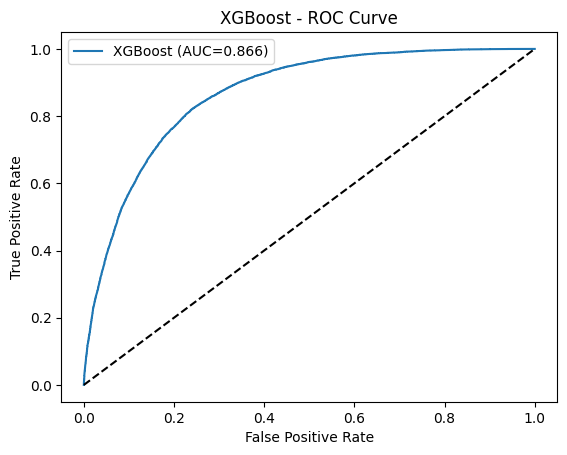


=== Baseline Results Summary ===
                     Accuracy  Precision    Recall        F1   ROC-AUC
Logistic Regression  0.694017   0.577572  0.333772  0.423062  0.736041
Random Forest        0.793453   0.733296  0.605838  0.663501  0.867094
XGBoost              0.794624   0.707809  0.662434  0.684371  0.866462


In [10]:
# ======================
# Cell 8: Baseline Models
# ======================

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: XGBoost
try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    print("⚠️ XGBoost not installed, skipping. (pip install xgboost to enable)")
    has_xgb = False

# Utility: evaluate a model
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name=""):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
    }
    if y_proba is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_test, y_proba)
    else:
        metrics["ROC-AUC"] = None
    
    print(f"\n=== {model_name} ===")
    for k, v in metrics.items():
        if v is None:
            print(f"{k}: N/A")
        else:
            print(f"{k}: {v:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Non-enzyme", "Enzyme"],
                yticklabels=["Non-enzyme", "Enzyme"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # ROC curve (if available)
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{model_name} (AUC={metrics['ROC-AUC']:.3f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} - ROC Curve")
        plt.legend()
        plt.show()
    
    return metrics

# ----------------------
# Train & Evaluate Models
# ----------------------

results = {}

# Logistic Regression
log_reg = LogisticRegression(max_iter=500, random_state=42)
results["Logistic Regression"] = evaluate_model(log_reg, X_train, y_train, X_test, y_test, "Logistic Regression")

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
results["Random Forest"] = evaluate_model(rf, X_train, y_train, X_test, y_test, "Random Forest")

# Feature importance for Random Forest
importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=feat_importances.values[:10], y=feat_importances.index[:10])
plt.title("Top 10 Feature Importances (Random Forest)")
plt.show()

# Optional: XGBoost
if has_xgb:
    xgb = XGBClassifier(
        n_estimators=300, learning_rate=0.1, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, use_label_encoder=False,
        eval_metric="logloss", random_state=42, n_jobs=-1
    )
    results["XGBoost"] = evaluate_model(xgb, X_train, y_train, X_test, y_test, "XGBoost")

# ----------------------
# Summary Table
# ----------------------
results_df = pd.DataFrame(results).T
print("\n=== Baseline Results Summary ===")
print(results_df)


In [ ]:
# ======================
# Cell 9: Cross-Validation + Tuning
# ======================

from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
import xgboost as xgb

# Define CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- Cross-validation helper ---
def run_cv(model, X, y, name):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    print(f"\n=== {name} CV Results ===")
    for metric in scoring:
        print(f"{metric}: {scores['test_'+metric].mean():.4f} ± {scores['test_'+metric].std():.4f}")
    return scores

# Logistic Regression CV
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
cv_lr = run_cv(log_reg, X, y, "Logistic Regression")

# Random Forest CV
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
cv_rf = run_cv(rf, X, y, "Random Forest")

# XGBoost CV
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_jobs=-1)
cv_xgb = run_cv(xgb_clf, X, y, "XGBoost")

# --- Hyperparameter Tuning ---
# Random Forest
rf_params = {
    "n_estimators": [200, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
}
grid_rf = GridSearchCV(rf, rf_params, cv=3, scoring="f1", n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)
print("\nBest RF params:", grid_rf.best_params_)
print("Best RF F1 (cv):", grid_rf.best_score_)

# XGBoost
xgb_params = {
    "n_estimators": [200, 500],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.8, 1.0],
}
grid_xgb = GridSearchCV(xgb_clf, xgb_params, cv=3, scoring="f1", n_jobs=-1, verbose=1)
grid_xgb.fit(X_train, y_train)
print("\nBest XGB params:", grid_xgb.best_params_)
print("Best XGB F1 (cv):", grid_xgb.best_score_)



=== Logistic Regression CV Results ===
accuracy: 0.6680 ± 0.0032
precision: 0.5044 ± 0.0034
recall: 0.7092 ± 0.0041
f1: 0.5895 ± 0.0026
roc_auc: 0.7376 ± 0.0027

=== Random Forest CV Results ===
accuracy: 0.7955 ± 0.0009
precision: 0.7350 ± 0.0031
recall: 0.6125 ± 0.0028
f1: 0.6682 ± 0.0013
roc_auc: 0.8679 ± 0.0010


/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=o


=== XGBoost CV Results ===
accuracy: 0.7904 ± 0.0015
precision: 0.6987 ± 0.0025
recall: 0.6616 ± 0.0052
f1: 0.6796 ± 0.0029
roc_auc: 0.8621 ± 0.0022
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best RF params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best RF F1 (cv): 0.66001647420023
Fitting 3 folds for each of 36 candidates, totalling 108 fits


/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:06:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:06:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:06:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/rithwik/miniconda3/envs/myenv1/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:06:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=o


Best XGB params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500, 'subsample': 0.8}
Best XGB F1 (cv): 0.7107631969150304
